# Data Flow Framework

In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import numpy.testing as npt
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

2018-02-10 19:27:57


In [641]:
import invisible_cities.dataflow.dataflow as fl
from invisible_cities.sierpe  import fee as FE

In [270]:
from functools   import wraps
from functools   import reduce
from contextlib  import contextmanager

In [505]:
from collections import namedtuple
from typing import  NamedTuple

In [689]:
import invisible_cities.core.system_of_units as units

## Generator functions in python

In Python a generator function contains at least one yield statement (it may contain other yield or return statements). Notice that, while a return statement terminates a function entirely, yield statement pauses the function saving all its states and later continues from there on successive calls.


## Differences between Generator function and a Normal function

Here is how a generator function differs from a normal function.

- Generator function contains one or more yield statement.

- When called, it returns an object (iterator) but does not start execution immediately.

- Methods like __iter__() and __next__() are implemented automatically. So we can iterate through the items using next().

- Once the function yields, the function is paused and the control is transferred to the caller.

- Local variables and their states are remembered between successive calls.

- Finally, when the function terminates, StopIteration is raised automatically on further calls.

In [12]:
# A simple generator function
def my_gen():
    n = 1
    print('This is printed first')
    # Generator function contains yield statements
    yield n

    n += 1
    print('This is printed second')
    yield n

    n += 1
    print('This is printed at last')
    yield n

In [22]:
g = my_gen()

In [23]:
g

<generator object my_gen at 0x1178fb7d8>

In [24]:
try:
    while True:
        next(g)
except StopIteration:
    print('generator is over')

This is printed first
This is printed second
This is printed at last
generator is over


In [25]:
for item in my_gen():
    print(item)


This is printed first
1
This is printed second
2
This is printed at last
3


### A generator that reverses a sequence

In [33]:
def rev_seq(seq):
    length = len(seq)
    for i in range(length - 1,-1,-1):
        yield seq[i]

In [34]:
for char in rev_seq("hello"):
     print(char)

o
l
l
e
h


In [36]:
for char in rev_seq((1,2,3,4,5)):
     print(char)

5
4
3
2
1


### A number generator

In [40]:
def generate_nums():
    num = 0
    while True:
        yield num
        num = num + 1
 

In [200]:
for x in generate_nums():
    print(x)
    if x > 4:
        break

0
1
2
3
4
5


### Python generator expressions

In [37]:
g = (x**2 for x in range(5))

In [38]:
g

<generator object <genexpr> at 0x117946e60>

In [39]:
for item in (x**2 for x in range(5)):
    print(item)

0
1
4
9
16


## Coroutines

Using generators we can pull data from a function context (and pause execution). What if we wanted to push some data too? That’s where coroutines comes into play. The yield keyword we use to pull values can also be used as an expression (on the right side of “=”) inside the function. We can use the send() method on a generator object to pass values back into the function. This is called “generator based coroutines”.

In [169]:
def coro():
    msg = yield "Hello"
    yield msg
 
c = coro()
print(next(c))
print(c.send("World"))

Hello
World


In [48]:
def generate_nums_in_range(first, last, step):
    for num in range(first, last, step):
        yield num
    num = 0

In [50]:
for n in generate_nums_in_range(1, 10, 3):
    print(n)

1
4
7


## Python's function decorators

### Python functions are first class objects

In Python, functions are first class citizens. Therefore we can:

- Assign functions to variables

In [170]:
def greet(name):
    return "hello " + name

greet_someone = greet
print(greet_someone("John"))

hello John


- Define functions inside other functions

In [171]:
def greet(name):
    def get_message():
        return "Hello "

    result = get_message() + name
    return result
print(greet_someone("John"))

hello John


- Functions can be passed as parameters to other functions

In [172]:
def greet(name):
    return "Hello " + name 

def call_func(func):
    other_name = "John"
    return func(other_name)  

print(call_func(greet))

Hello John


- Functions can return other functions

In [173]:
def compose_greet_func():
    def get_message():
        return "Hello there!"

    return get_message

greet = compose_greet_func()
print(greet())

Hello there!


- Inner functions have access to the enclosing scope

- More commonly known as a *closure*. A very powerful pattern that we will come across while building decorators. Another thing to note, Python only allows read access to the outer scope and not assignment. Notice how we modified the example above to read a "name" argument from the enclosing scope of the inner function and return the new function.

In [174]:
def compose_greet_func(name):
    def get_message():
        return "Hello there " + name + "!"

    return get_message

greet = compose_greet_func("John")
print(greet())

Hello there John!


### Composition of decorators

- Function decorators are simply wrappers to existing functions. Putting the ideas mentioned above together, we can build a decorator. In this example let's consider a function that wraps the string output of another function by p tags.

In [179]:
def get_text(name):
    return "lorem ipsum, {0} dolor sit amet".format(name)

def p_decorate(func):
    def func_wrapper(name):
        return "<p>{0}</p>".format(func(name))
    return func_wrapper

my_get_text = p_decorate(get_text)

print(get_text("John"))
print(my_get_text("John"))

lorem ipsum, John dolor sit amet
<p>lorem ipsum, John dolor sit amet</p>


In [180]:
get_text = p_decorate(get_text)
print(get_text("John"))

<p>lorem ipsum, John dolor sit amet</p>


In [181]:
@p_decorate
def get_text(name):
    return "lorem ipsum, {0} dolor sit amet".format(name)

print(get_text("John"))

<p>lorem ipsum, John dolor sit amet</p>


## The dataflow framework

### Bricks

- source: our data source
- sink  : every pipe needs to end into a sink
- pipeline: defines flow of data


In [228]:
# We avoid using a lazy source so that we can compare the result
# with the input
the_source = list(range(10))

In [229]:
def simplest_pipeline(the_source):

    # The simplest possible pipeline has one source directly connected
    # to one sink.

    # In this example the sink will simply collect the data it
    # receives, into a list.
    result = []
    the_sink = fl.sink(result.append)

    # Use 'push' to feed the source into the pipe.
    fl.push(source=the_source, pipe=the_sink)

    return result

In [230]:
result = simplest_pipeline(the_source)
result

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [231]:
def simple_fork(the_source):

    # Dataflows can be split with 'fork'

    left  = [];  left_sink = fl.sink( left.append)
    right = []; right_sink = fl.sink(right.append)

    fl.push(source = the_source,
            pipe   = fl.fork( left_sink,
                             right_sink))

    return left, right

In [232]:
left, right = simple_fork(the_source)
print(left)
print(right)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [233]:
def square(n): 
    return n*n

In [234]:
def simple_map(the_source, the_operation):

    # The pipelines start to become interesting when the data are
    # transformed in some way. 'map' transforms every item passing
    # through the pipe by applying the supplied operation.


    square = fl.map(the_operation)
    result = []
    the_sink = fl.sink(result.append)

    fl.push(source = the_source,
            pipe   = square(the_sink))

    return result

In [235]:
result = simple_map(the_source, square)
result

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [240]:
def simple_pipe(the_source, the_operation):

    # The basic syntax requires any element of a pipeline to be passed
    # as argument to the one that precedes it. This looks strange to
    # the human reader, especially when using parametrized
    # components. 'pipe' allows construction of pipes from a sequence
    # of components.

    # Using 'pipe', 'test_map' could have been written like this:


    result = []
    the_sink = fl.sink(result.append)
    square = fl.map(the_operation)
    fl.push(source = the_source,
            pipe   = fl.pipe(square, the_sink))

    return result

In [241]:
result = simple_pipe(the_source, square)
result

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [244]:
def longer_pipeline(the_source):

    # Pipelines can have arbitrary lengths

    result = []
    the_sink = fl.sink(result.append)

    fl.push(source = the_source,
            pipe   = fl.pipe(fl.map(lambda n:n+1),
                             fl.map(lambda n:n*2),
                             fl.map(lambda n:n-3),
                             fl.map(lambda n:n/4),
                             the_sink))

    return result

In [245]:
result = longer_pipeline(the_source)
result

[-0.25, 0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25]

In [255]:
def odd(n): 
    return n % 2

In [256]:
def even(n): 
    return not odd(n)

In [257]:
even(2)

True

In [258]:
odd(2)

0

In [251]:
def simple_filter(the_source, the_predicate):

    # 'filter' can be used to eliminate data

    
    odd = fl.filter(the_predicate)
    result = []
    the_sink = fl.sink(result.append)

    fl.push(source = the_source,
            pipe   = fl.pipe(odd, the_sink))

    return result


In [252]:
result = simple_filter(the_source, odd)
result

[1, 3, 5, 7, 9]

In [253]:
def simple_count(the_source):

    # 'count' is an example of a sink which only produces a result
    # once the stream of data flowing into the pipeline has been
    # closed. Such results are retrieved from futures which are
    # created at the time a 'count' instance is created: a namedtuple
    # containing the sink and its corresponding future is returned.

    count = fl.count()

    fl.push(source = the_source,
            pipe   = count.sink)

    return count.future.result() 

In [254]:
result = simple_count(the_source)
result

10

In [259]:
def count_futures(the_source):

    # 'push' provides a higher-level interface to using such futures:
    # it optionally accepts a tuple of futures, and returns a tuple of
    # their results

    count_all  = fl.count()
    count_even = fl.count()
    count_odd  = fl.count()

    result = fl.push(source = the_source,
                     pipe   = fl.fork(                          count_all.sink,
                                      fl.pipe(fl.filter(odd),   count_odd.sink),
                                      fl.pipe(fl.filter(even), count_even.sink)),
                     result = (count_odd.future, count_even.future, count_all.future))

    return result

In [260]:
result = count_futures(the_source)
result

(5, 5, 10)

In [266]:
def simple_reduce(the_source):

    # 'reduce' provides a high-level way of creating future-sinks such
    # as 'count'

    # Make a component just like df.sum
    from operator import add
    total = fl.reduce(add, initial=0)

    # Create two instances of it, which will be applied to different
    # (forked) sub-streams in the network
    total_all = total()
    total_odd = total()
    total_even = total()


    result = fl.push(source = the_source,
                     pipe   = fl.fork(                        total_all.sink,
                                      fl.pipe(fl.filter(odd), total_odd.sink),
                                      fl.pipe(fl.filter(odd), total_even.sink)),
                     result = (total_all.future, total_odd.future, total_even.future))

    return result

In [267]:
result = simple_reduce(the_source)
result

(45, 25, 25)

In [271]:
from operator import add
reduce(add, the_source)

45

In [272]:
reduce(add, filter(odd,the_source))

25

In [273]:
reduce(add, filter(even,the_source))

20

In [276]:
def simple_spy( the_source):

    # 'spy' performs an operation on the data streaming through the
    # pipeline, without changing what is seen downstream. An obvious
    # use of this would be to insert a 'spy(print)' at some point in
    # the pipeline to observe the data flow through that point.


    result = []; the_sink = fl.sink(result.append)
    the_spy  = fl.spy ( lambda n: print(n))

    fl.push(source = the_source,
            pipe   = fl.pipe(the_spy, the_sink))

    return result

In [277]:
result = simple_spy(the_source)
result

0
1
2
3
4
5
6
7
8
9


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [280]:
def simple_branch(the_source):

    # 'branch', like 'spy', allows you to insert operations on a copy
    # of the stream at any point in a network. In contrast to 'spy'
    # (which accepts a single plain operation), 'branch' accepts an
    # arbitrary number of pipeline components, which it combines into
    # a pipeline. It provides a more convenient way of constructing
    # some graphs that would otherwise be constructed with 'fork'.

    # Some pipeline components
    c1 = []; C1 = fl.sink(c1.append)
    c2 = []; C2 = fl.sink(c2.append)
    e1 = []; E1 = fl.sink(e1.append)
    e2 = []; E2 = fl.sink(e2.append)

    A = fl.map(lambda n:n+1)
    B = fl.map(lambda n:n*2)
    D = fl.map(lambda n:n*3)

    # Two eqivalent networks, one constructed with 'fork' the other
    # with 'branch'.
    graph1 = fl.pipe(A, fl.fork(fl.pipe(B,C1),
                                fl.pipe(D,E1)))

    graph2 = fl.pipe(A, fl.branch(B,C2), D,E2)

    # Feed the same data into the two networks.
   
    fl.push(source=the_source, pipe=graph1)
    fl.push(source=the_source, pipe=graph2)

    # Confirm that both networks produce the same results.
    return c1, c2, e1,e2


In [281]:
c1, c2, e1,e2 = simple_branch(the_source)

In [282]:
print(c1,e1)
print(c2,e2)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20] [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
[2, 4, 6, 8, 10, 12, 14, 16, 18, 20] [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]


In [283]:
def chain_pipes(the_source):

    # Pipelines must end in sinks. If the last component of a pipe is
    # not a sink, the pipe may be used as a component in a bigger
    # pipeline, but it will be impossible to feed any data into it
    # until it is connected to some other component which ends in a
    # sink.

    # Some basic pipeline components
    s1 = []; sink1 = fl.sink(s1.append)
   
    A = fl.map(lambda n:n+1)
    B = fl.map(lambda n:n*2)
    C = fl.map(lambda n:n-3)

    graph1 = fl.pipe(A, B, C, sink1)
   
    fl.push(source=the_source, pipe=graph1)

    return s1

In [284]:
s1 = chain_pipes(the_source)
s1

[-1, 1, 3, 5, 7, 9, 11, 13, 15, 17]

## More involved examples

In [506]:
class Point(NamedTuple):
    x     : float
    y     : float

In [458]:
class WfmPar(NamedTuple):
    t_tot     : int
    t_pre     : int
    t_rise_s2 : int 
    t_flat_s2 : int
    noise     : int
    q_s2      : int

In [549]:
class Waveform(NamedTuple):
    t   : np.ndarray
    q   : np.ndarray

In [550]:
w = Waveform(np.zeros(10), np.ones(10))

In [551]:
w

Waveform(t=array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), q=array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]))

In [507]:
def line(x : float, p1 : Point, p2 : Point) ->float:
    def coef(p1, p2) ->float:
        b = (p2.y - p1.y) / (p2.x - p1.x)
        a = (p1.y * p2.x - p2.y * p1.x) / (p2.x - p1.x)
        return a, b
    a, b = coef(p1, p2)
    return a + b * x

In [508]:
p1 = Point(1,1)
p2 = Point(2,2)

In [512]:
[line(x, p1, p2) == x for x in range(10)]

[True, True, True, True, True, True, True, True, True, True]

In [513]:
np.testing.assert_array_equal([line(x, p1, p2) == x for x in range(10)], np.ones(10))

In [600]:
def waveform(wp : WfmPar):
    t_s2 = 2 * wp.t_rise_s2 + wp.t_flat_s2
    t_pos = wp.t_tot - wp.t_pre - t_s2
    assert t_s2 + wp.t_pre < wp.t_tot
    
    def wf_noise(length):
        return wp.noise * np.random.randn(length)
        
    t          = np.arange(wp.t_tot)
    sgn_pre    = np.zeros(wp.t_tot)
    sgn_s2     = np.zeros(wp.t_tot)
    sgn_post   = np.zeros(wp.t_tot)
    
    # waveform pre (before signal raises)
    f = 0
    l = wp.t_pre
    sgn_pre[f:l] = wf_noise(wp.t_pre)
    
    # signal raise
    f = l
    l = f + wp.t_rise_s2 
    p1 = Point(t[f], 0)
    p2 = Point(t[l], wp.q_s2)
    sgn_s2[f:l+1] = line(t[f:l+1], p1, p2) + wf_noise(l+1-f)
   
    # signal flattens
    f = l 
    l = f + wp.t_flat_s2
    sgn_s2[f:l] = wp.q_s2  + wf_noise(l-f)


    # signal decreases
    f = l
    l = f + wp.t_rise_s2
    p1 = Point(t[f], wp.q_s2)
    p2 = Point(t[l], 0)
    sgn_s2[f:l+1] = line(t[f:l+1], p1, p2)  + wf_noise(l+1-f)
    
    # signal post (after signal has decreases)
    f = l 
    l = wp.t_tot 
    sgn_post[f:l] = wp.noise * np.random.randn(t_pos) 
    
    return Waveform(t, sgn_pre + sgn_s2 + sgn_post)
        
    

In [625]:
x = np.arange(10)

In [626]:
x[1:]

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [627]:
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [629]:
def add_waveforms(wfm_list):
    wf0 = wfm_list[0]
    t = wf0.t
    q = wf0.q
    
    for wf in wfm_list[1:]:
        q += wf.q
    
    return Waveform(t, q)


In [632]:
s2p = WfmPar(t_tot=300,t_pre=100,t_rise_s2=20,t_flat_s2=5,noise=1,q_s2=500)
s2p

WfmPar(t_tot=300, t_pre=100, t_rise_s2=20, t_flat_s2=5, noise=1, q_s2=500)

In [633]:
s2 = waveform(s2p)

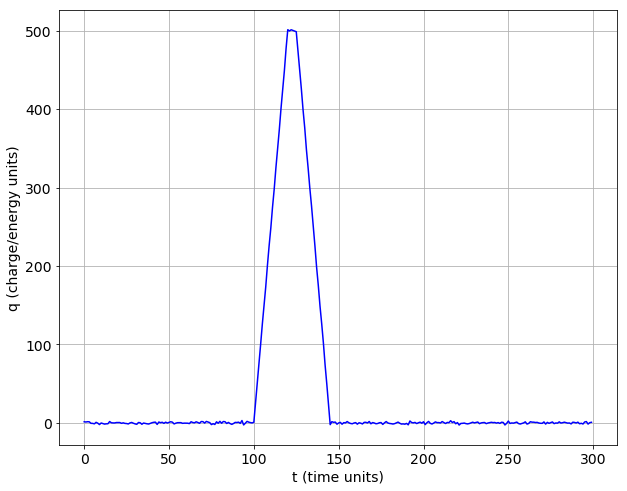

In [634]:
plt.plot(s2.t,s2.q,'b')
plt.grid(True)
plt.xlabel(r't (time units)')
plt.ylabel(r'q (charge/energy units)')
#plt.text(12, 250, r'$E ={0:5.1f} \,\, kV/cm$'.format(E15))

In [635]:
s1p = WfmPar(t_tot=300,t_pre=50,t_rise_s2=5,t_flat_s2=1,noise=1,q_s2=20)
s1p

WfmPar(t_tot=300, t_pre=50, t_rise_s2=5, t_flat_s2=1, noise=1, q_s2=20)

In [636]:
s1 = waveform(s1p)

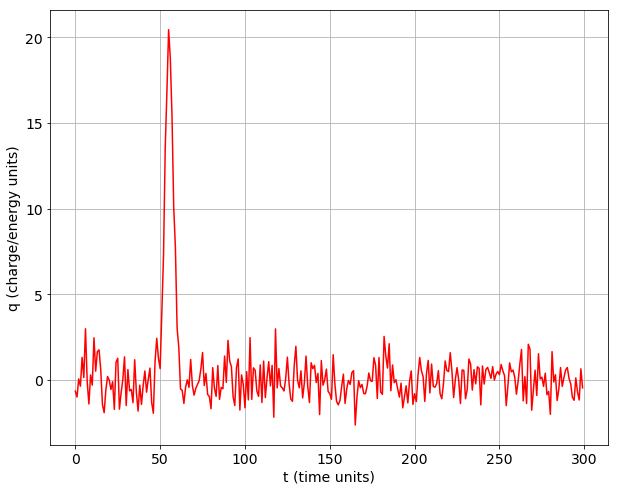

In [637]:
plt.plot(s1.t,s1.q,'r')
plt.grid(True)
plt.xlabel(r't (time units)')
plt.ylabel(r'q (charge/energy units)')
#plt.text(12, 250, r'$E ={0:5.1f} \,\, kV/cm$'.format(E15))

In [638]:
wf = add_waveforms((s1, s2))

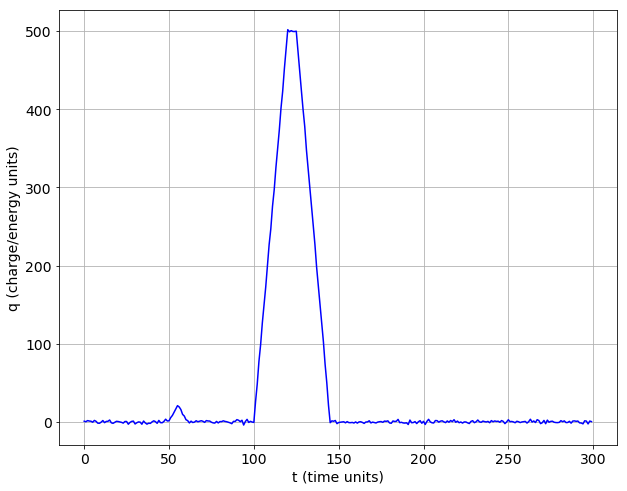

In [639]:
plt.plot(wf.t,wf.q,'b')
plt.grid(True)
plt.xlabel(r't (time units)')
plt.ylabel(r'q (charge/energy units)')
#plt.text(12, 250, r'$E ={0:5.1f} \,\, kV/cm$'.format(E15))

In [670]:
def simulate_pmt_response(wf):
    # Single Photoelectron class
    spe = FE.SPE()
    # FEE, with noise PMT
    fee  = FE.FEE(0, noise_FEEPMB_rms=FE.NOISE_I, noise_DAQ_rms=FE.NOISE_DAQ)
    # signal_i in current units
    signal_i = FE.spe_pulse_from_vector(spe, wf.q) 
    signal_fee = FE.signal_v_fee(fee, signal_i, -1) * 1e+6
    
    return Waveform(wf.t, signal_i * 1e-7), Waveform(wf.t, signal_fee) 

In [671]:
wf_i, wf_fee = simulate_pmt_response(wf)

In [672]:
signal_i, signal_fee = wf_i.q, wf_fee.q

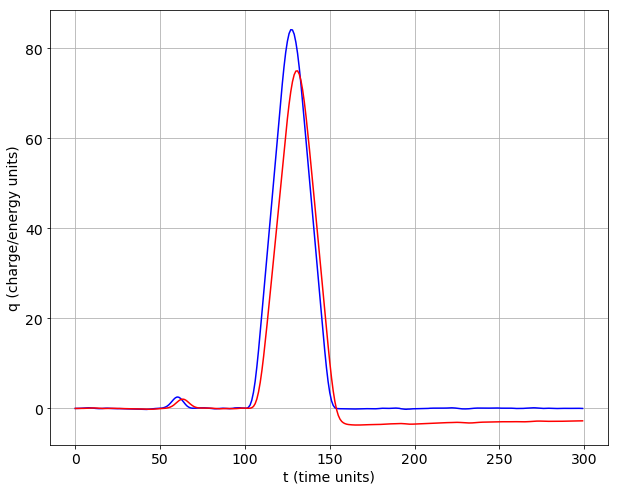

In [673]:
plt.plot(signal_i,'b')
plt.plot(signal_fee,'r')
plt.grid(True)
plt.xlabel(r't (time units)')
plt.ylabel(r'q (charge/energy units)')

In [686]:
s2p = WfmPar(t_tot=5000,t_pre=500,t_rise_s2=20,t_flat_s2=1000,noise=1,q_s2=100)
s1p = WfmPar(t_tot=5000,t_pre=250,t_rise_s2=5,t_flat_s2=1,noise=1,q_s2=20)
s2 = waveform(s2p)
s1 = waveform(s1p)
wf = add_waveforms((s1, s2))
wf_i, wf_fee = simulate_pmt_response(wf)

In [687]:
signal_i, signal_fee = wf_i.q, wf_fee.q

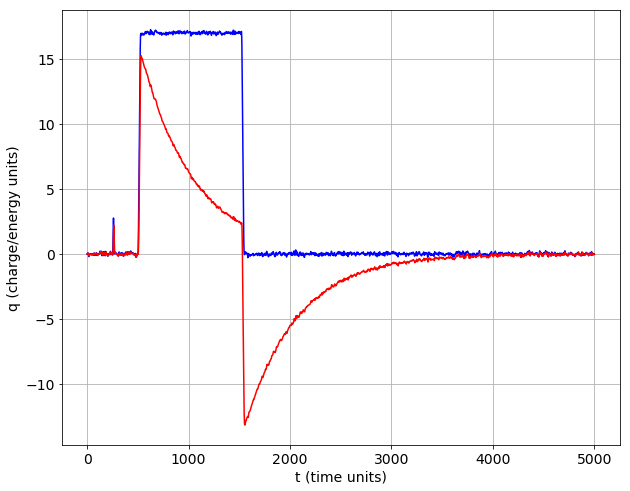

In [688]:
plt.plot(signal_i,'b')
plt.plot(signal_fee,'r')
plt.grid(True)
plt.xlabel(r't (time units)')
plt.ylabel(r'q (charge/energy units)')

In [690]:
b = np.array([[1,2,3], [4,5,6], [7,8,9]])

In [691]:
b.shape

(3, 3)

In [693]:
b

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [694]:
def average(a):
    return (a[0] + a[-1]) * 0.5

In [695]:
np.apply_along_axis(average, 0, b)

array([ 4.,  5.,  6.])

In [696]:
np.apply_along_axis(average, 1, b)

array([ 2.,  5.,  8.])